**Step 1: Load and Clean Data**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\bezis\Downloads\Brent-Oil-Insights\data\raw\BrentOilPrices.csv")

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.sort_values('Date').dropna()

prices = data['Price'].values
dates = data['Date'].values

C:\Users\bezis\AppData\Local\Temp\ipykernel_23420\1403042462.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


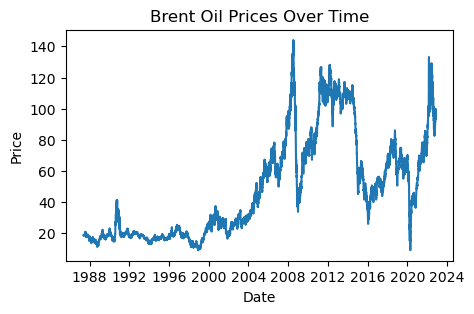

In [2]:
plt.figure(figsize=(5,3))
plt.plot(data['Date'], data['Price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

**STEP 2 — Build Bayesian Change Point Model (PyMC)**


In [3]:
import pymc as pm
import arviz as az

In [4]:
with pm.Model() as model:

    # 1️⃣ Prior for change point (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(prices)-1)

    # 2️⃣ Priors for means
    mu_1 = pm.Normal("mu_1", mu=np.mean(prices), sigma=20)
    mu_2 = pm.Normal("mu_2", mu=np.mean(prices), sigma=20)

    # 3️⃣ Prior for standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # 4️⃣ Switch function
    mu = pm.math.switch(tau >= np.arange(len(prices)), mu_1, mu_2)

    # 5️⃣ Likelihood
    observation = pm.Normal("obs", mu=mu, sigma=sigma, observed=prices)

    # 6️⃣ Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.


- Check Convergence


In [5]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4519.916,3.154,4513.000,4525.000,0.077,0.067,1699.0,1577.0,1.0
mu_1,21.424,0.276,20.897,21.935,0.003,0.003,11329.0,6277.0,1.0
mu_2,75.600,0.282,75.058,76.123,0.002,0.003,13069.0,5999.0,1.0
sigma,18.590,0.139,18.329,18.856,0.001,0.002,13717.0,6493.0,1.0


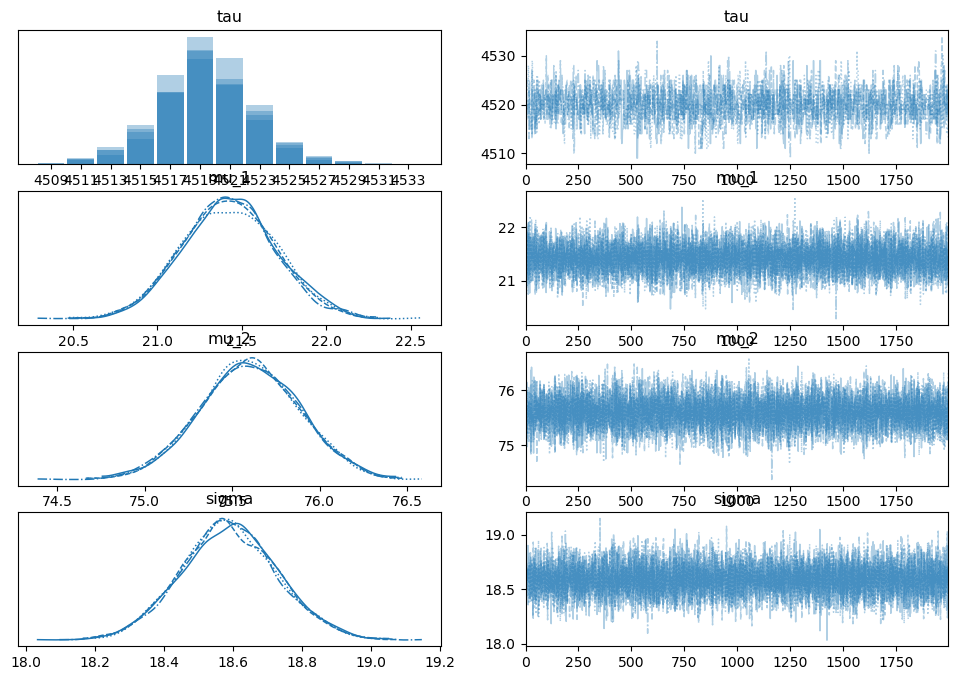

In [6]:
az.plot_trace(trace)
plt.show()

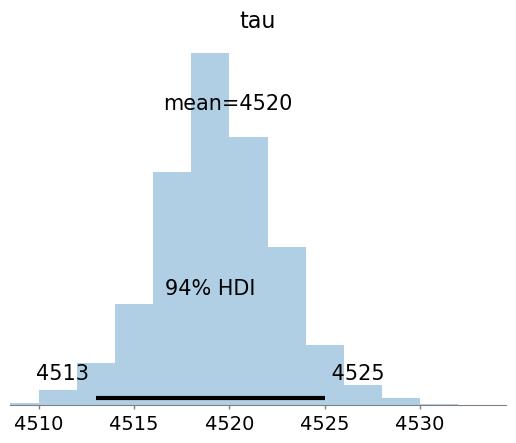

In [7]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()

In [8]:
tau_samples = trace.posterior["tau"].values.flatten()
estimated_tau = int(np.mean(tau_samples))

change_date = data.iloc[estimated_tau]["Date"]

print("Estimated Change Point Date:", change_date)

Estimated Change Point Date: 2005-02-22 00:00:00


In [9]:
mu1_mean = trace.posterior["mu_1"].mean().values
mu2_mean = trace.posterior["mu_2"].mean().values

percent_change = ((mu2_mean - mu1_mean) / mu1_mean) * 100

print(f"Before mean price: ${mu1_mean:.2f}")
print(f"After mean price: ${mu2_mean:.2f}")
print(f"Percent change: {percent_change:.2f}%")

Before mean price: $21.42
After mean price: $75.60
Percent change: 252.87%
